In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad,simps
import os,sys
sys.path.append('../')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
import numpy as np
import scipy.constants as constants

In [5]:
nMasses=100
nZs=100

In [6]:
zs = np.linspace(0.07,5,nZs) # redshifts
ms = np.geomspace(2e10,1e17,nMasses) # masses
ks = np.geomspace(1e-4,100,1001) # wavenumbers

In [7]:
hcos = hm.HaloModel(zs,ks,ms=ms,mass_function='tinker',mdef='mean')
hcos.add_battaglia_pres_profile("y",family="pres",xmax=2,nxs=30000)

/home/dpirvu/hmvec/examples/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [8]:

Pyy = hcos.get_power("y","y",verbose=False)

Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [9]:
ells = np.linspace(50,10000,100)
Cyy = hcos.C_yy(ells,zs,ks,Pyy)

Text(0, 0.5, '$C_\\ell \\ell^2/(2 \\pi)$')

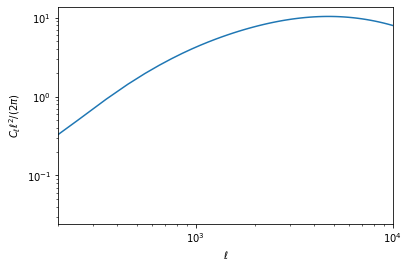

In [11]:
plt.loglog(ells,ells**2*Cyy*hm.default_params['T_CMB']**2/2./np.pi)#*hm.default_params['T_CMB']**2
plt.yscale('log') 
plt.xlim([200,10000])
plt.xlabel('$\ell$')
plt.ylabel("$C_\ell \ell^2/(2 \pi)$")



In [12]:
rhocritz=hcos.rho_critical_z(hcos.zs)
delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)

rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)*.7
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)*.7

# Generate profiles
"""
The physical profile is rho(r) = f(2r/R200)
We rescale this to f(x), so x = r/(R200/2) = r/rgs
So rgs = R200/2 is the equivalent of rss in the NFW profile
"""
omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0
presFunc = lambda x: hm.P_e_generic_x(x,m200critz[...,None],r200critz[...,None],
                                  hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                            alpha=hm.default_params['battaglia_pres_alpha'],
                            gamma=hm.default_params['battaglia_pres_gamma'],
                            P0_A0=hm.battaglia_defaults['pres']['P0_A0'],
                            P0_alpham=hm.battaglia_defaults['pres']['P0_alpham'],
                            P0_alphaz=hm.battaglia_defaults['pres']['P0_alphaz'],
                            xc_A0=hm.battaglia_defaults['pres']['xc_A0'],
                            xc_alpham=hm.battaglia_defaults['pres']['xc_alpham'],
                            xc_alphaz=hm.battaglia_defaults['pres']['xc_alphaz'],
                            beta_A0=hm.battaglia_defaults['pres']['beta_A0'],
                            beta_alpham=hm.battaglia_defaults['pres']['beta_alpham'],
                            beta_alphaz=hm.battaglia_defaults['pres']['beta_alphaz'])

rhofunc = lambda x: hm.rho_gas_generic_x(x,m200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                                    gamma=hm.default_params['battaglia_gas_gamma'],
                                    rho0_A0=hm.battaglia_defaults['AGN']['rho0_A0'],
                                    rho0_alpham=hm.battaglia_defaults['AGN']['rho0_alpham'],
                                    rho0_alphaz=hm.battaglia_defaults['AGN']['rho0_alphaz'],
                                    alpha_A0=hm.battaglia_defaults['AGN']['alpha_A0'],
                                    alpha_alpham=hm.battaglia_defaults['AGN']['alpha_alpham'],
                                    alpha_alphaz=hm.battaglia_defaults['AGN']['alpha_alphaz'],
                                    beta_A0=hm.battaglia_defaults['AGN']['beta_A0'],
                                    beta_alpham=hm.battaglia_defaults['AGN']['beta_alpham'],
                                    beta_alphaz=hm.battaglia_defaults['AGN']['beta_alphaz'])

In [13]:
sigmaT=constants.physical_constants['Thomson cross section'][0] # units m^2
mElect=constants.physical_constants['electron mass'][0] #/ default_params['mSun']# units kg
c_light = constants.c 
XH=.76
eFrac=2.0*(XH+1.0)/(5.0*XH+3.0)
G_newt = constants.G/(hm.default_params['parsec']*1e6)**3*hm.default_params['mSun']
norm=eFrac*(omb/omm)*G_newt *200*rhocritz[...,None]*m200critz/(2*r200critz)

In [14]:
tmpX=np.arange(0.03,4,.01)

In [ ]:

plt.figure(figsize=(8,8))
for i in range(0,nZs,5):
    plt.loglog(tmpX,(presFunc(tmpX)/norm[...,None])[i,-20]*tmpX**3,label="{:.2f}".format(zs[i]))
plt.ylabel("$P/P_{200}  (r/r_{200})^3$",fontsize=27)
plt.xlabel('$r/r_{200}$',fontsize=27)
plt.ylim([0.001,.2])
plt.xlim([0.03,3])
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
for i in range(30,nMasses,10):
    plt.loglog(tmpX,(presFunc(tmpX)/norm[...,None])[0,i]*tmpX**3,label="{:.2E}".format(ms[i]))
plt.ylabel("$P/P_{200}  (r/r_{200})^3$",fontsize=27)
plt.xlabel('$r/r_{200}$',fontsize=27)
plt.legend()
plt.ylim([0.001,.2])
plt.xlim([0.03,3])
plt.show()